In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

data = scipy.io.loadmat('qm7.mat')

R = data['R']
Z = data['Z']
T = data['T'].flatten()

### Compute Inter-atomic Distance

In [2]:
def compute_distances(R):
    n_molecules = R.shape[0]
    max_atoms = R.shape[1]
    distances = np.zeros((n_molecules, max_atoms, max_atoms))
    
    for i in range(n_molecules):
        for j in range(max_atoms):
            for k in range(j+1, max_atoms):
                if Z[i, j] != 0 and Z[i, k] != 0:
                    distances[i, j, k] = np.linalg.norm(R[i, j] - R[i, k])
                    distances[i, k, j] = distances[i, j, k]
    
    return distances

distances = compute_distances(R)

### 1.1 Visualizing Molecules
There are a variety of libraries for rendering molecular geometries with various degrees of sophistication. A quick and dirty approach is to use the scatter plot function of matplotlib, where each point is an atom (e.g. plotted according to its xy-coordinates and discarding the z-coordinate). Note that bonds are not provided as part of QM7 because they are strictly speaking not needed to infer chemical properties (bonds can be derived from atom coordinates). To better visualize the molecule, one can draw connections between nearby atoms by plotting a line between two atoms if the Euclidean distance between the two is smaller than a fixed threshold.

In [3]:
def visualize_molecule(R, Z, index, ax):
    coordinates = R[index]
    atoms = Z[index]
    
    # Plot atoms
    for i in range(len(atoms)):
        if atoms[i] != 0:
            ax.scatter(coordinates[i, 0], coordinates[i, 1], label=f'Atom {atoms[i]}')
    
    # Plot bonds (edges) if distance is less than a threshold (e.g., 1.6 Angstroms)
    threshold = 1.6
    for i in range(len(atoms)):
        for j in range(i + 1, len(atoms)):
            if atoms[i] != 0 and atoms[j] != 0:
                distance = np.linalg.norm(coordinates[i] - coordinates[j])
                if distance < threshold:
                    ax.plot([coordinates[i, 0], coordinates[j, 0]], 
                             [coordinates[i, 1], coordinates[j, 1]], 'k-')
    
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title(f'Molecule {index}')
    ax.legend()

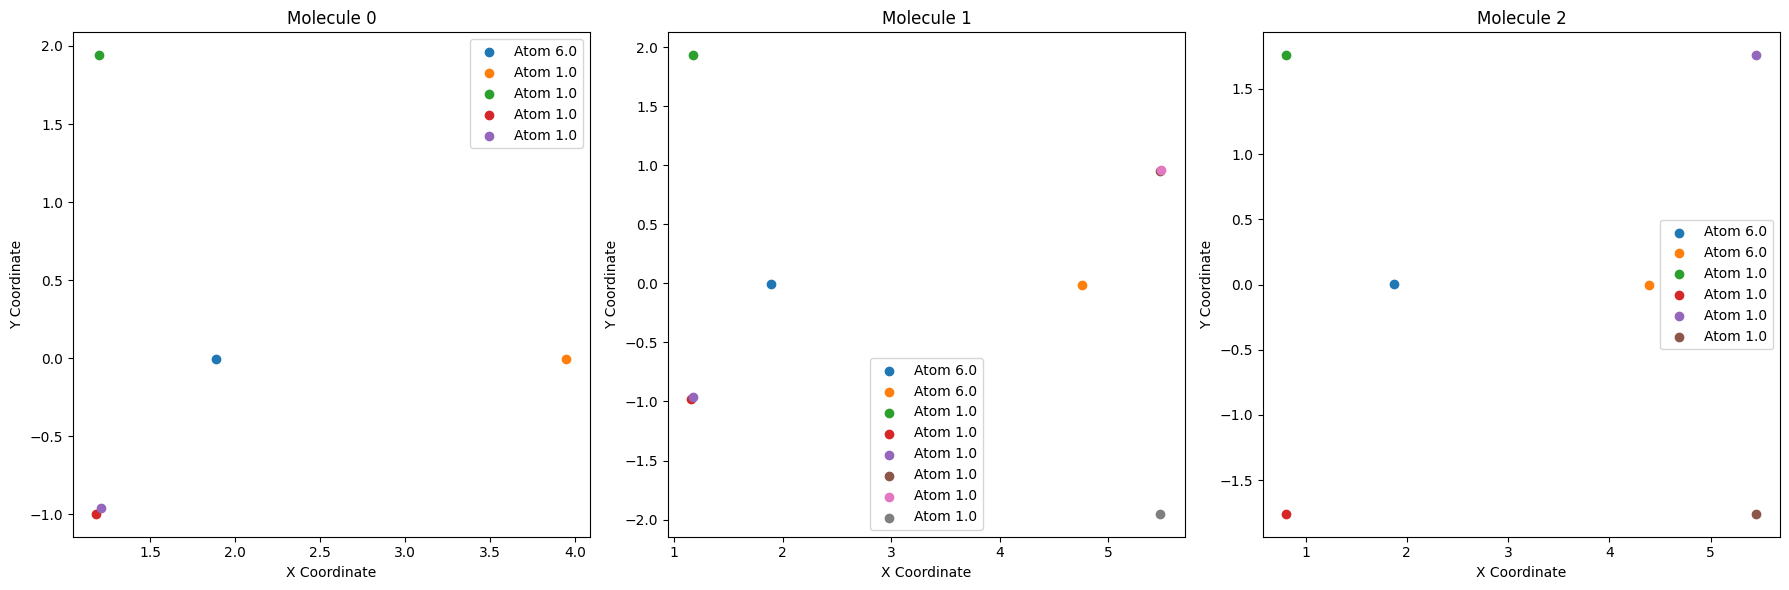

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i in range(3):
    visualize_molecule(R, Z, i, axes[i])

plt.tight_layout()
plt.show()

## 2 Data Representation, ML Model and Explanations
To predict the relation between molecular geometry and atomization energy, we will consider a ridge regression model with a particular summing structure. This model will have the advantage of being reasonably accurate and enabling an insightful exploration of the predicted quantum-chemical relation.

### 2.1 Data Representation

To represent each molecule 𝑀 as a feature vector, we use a one-hot encoding of the atom types. This involves creating a binary vector for each atom type present in the dataset (H, C, N, O, S).

The overall feature vector 𝑥 for a molecule is then obtained by summing the one-hot encoded vectors of all its atoms.

1. One-hot encoding for each atom type:

H: [1, 0, 0, 0, 0]\
C: [0, 1, 0, 0, 0]\
N: [0, 0, 1, 0, 0]\
O: [0, 0, 0, 1, 0]\
S: [0, 0, 0, 0, 1]

2. Summing the representations for all atoms in a molecule to form a feature vector 𝑥:

The feature vector $x$ is given by:

$$
x = \sum_{i=1}^{|M|} \phi(E_i)
$$

where $\phi(E_i)$ is the one-hot encoding of atom $E_i$.


In [5]:
def create_features(Z):
    n_molecules = Z.shape[0]
    max_atoms = Z.shape[1]
    
    # Atom types: H (1), C (6), N (7), O (8), S (16)
    atom_types = [1, 6, 7, 8, 16]
    atom_index = {atom: i for i, atom in enumerate(atom_types)}
    
    # Initialize the feature matrix
    feature_matrix = np.zeros((n_molecules, len(atom_types)))
    
    for i in range(n_molecules):
        for j in range(max_atoms):
            atomic_number = Z[i, j]
            if atomic_number in atom_index:
                feature_matrix[i, atom_index[atomic_number]] += 1
    
    return feature_matrix, atom_index

In [6]:
feature_matrix, atom_index = create_features(Z)
print(feature_matrix[:5])

[[4. 1. 0. 0. 0.]
 [6. 2. 0. 0. 0.]
 [4. 2. 0. 0. 0.]
 [2. 2. 0. 0. 0.]
 [6. 2. 0. 1. 0.]]


### 2.2 Ridge Regression Model

We build a ridge regression model using the feature matrix. Ridge regression minimizes the following objective:

$$
J(w) = \mathbb{E} \left[ (w^\top x - t)^2 + \lambda \| w \|^2 \right]
$$

The closed-form solution for $w$ is:

$$
w = \left( \Sigma_{xx} + \lambda I \right)^{-1} \Sigma_{xt}
$$

where $\Sigma_{xx}$ is the auto-covariance matrix and $\Sigma_{xt}$ is the cross-covariance matrix.


In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, T, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the ridge regression model
lambda_values = np.logspace(-5, 5, 100)
best_lambda = None
best_score = float('inf')

for l in lambda_values:
    ridge = Ridge(alpha=l)
    ridge.fit(X_train, y_train)
    score = ridge.score(X_test, y_test)
    if score < best_score:
        best_score = score
        best_lambda = l

# Train the best model
ridge = Ridge(alpha=best_lambda)
ridge.fit(X_train, y_train)

# Evaluate the model
train_score = ridge.score(X_train, y_train)
test_score = ridge.score(X_test, y_test)
print(f'Best lambda: {best_lambda}')
print(f'Training score: {train_score}')
print(f'Test score: {test_score}')

Best lambda: 100000.0
Training score: 0.15010998250049645
Test score: 0.14948118632866114


### 2.3 Deeper Insights with Explanations

While the procedure above would allow us to determine whether the molecular property is predictable from the data given as the input, an important insight on its own, this result is of limited use as it does not tell us what in the molecule has contributed to the low/high energy prediction. Interestingly, this an explanation to this question is readily given by looking at the structure of the model:

$$
f(x) = w^\top x = w^\top \left( \sum_{i=1}^{|M|} \phi(E_i) \right) = \sum_{i=1}^{|M|} w^\top \phi(E_i) = \sum_{i=1}^{|M|} R_i
$$

The term $R_i$ indentifies the contribution of the element $i$ of the molecule to the overall prediction. Lastly, expressing $R_i$ as a function of the element’s property, we can identify how a modification of the given element (e.g. a change of atom type) affects the contribution of that element to the molecular property.

The contribution $R_i$ of each atom $i$ to the overall prediction can be expressed as:

$$
f(x) = w^\top x = w^\top \left( \sum_{i=1}^{|M|} \phi(E_i) \right) = \sum_{i=1}^{|M|} w^\top \phi(E_i) = \sum_{i=1}^{|M|} R_i
$$

where:

$$
R_i = w^\top \phi(E_i)
$$

This means $R_i$ is the contribution of atom $i$ to the overall prediction, which can be used to understand how changes in atom types affect the predicted atomization energy.

In [8]:
def compute_contributions(ridge_model, atom_types, atom_index, Z):
    contributions = []
    for i in range(Z.shape[0]):
        molecule_contribution = []
        for j in range(Z.shape[1]):
            atomic_number = Z[i, j]
            if atomic_number in atom_index:
                one_hot = np.zeros(len(atom_types))
                one_hot[atom_index[atomic_number]] = 1
                R_i = ridge_model.coef_ @ one_hot
                molecule_contribution.append((atomic_number, R_i))
        contributions.append(molecule_contribution)
    return contributions

In [9]:
# Compute contributions for the test set
contributions = compute_contributions(ridge, [1, 6, 7, 8, 16], atom_index, Z)

# Print contributions for the first 3 molecules
for i in range(3):
    print(f"Molecule {i+1} contributions:")
    for atomic_number, contribution in contributions[i]:
        print(f"Atom type {atomic_number}: {contribution}")

Molecule 1 contributions:
Atom type 6.0: -7.902516158226502
Atom type 1.0: -10.983898025035673
Atom type 1.0: -10.983898025035673
Atom type 1.0: -10.983898025035673
Atom type 1.0: -10.983898025035673
Molecule 2 contributions:
Atom type 6.0: -7.902516158226502
Atom type 6.0: -7.902516158226502
Atom type 1.0: -10.983898025035673
Atom type 1.0: -10.983898025035673
Atom type 1.0: -10.983898025035673
Atom type 1.0: -10.983898025035673
Atom type 1.0: -10.983898025035673
Atom type 1.0: -10.983898025035673
Molecule 3 contributions:
Atom type 6.0: -7.902516158226502
Atom type 6.0: -7.902516158226502
Atom type 1.0: -10.983898025035673
Atom type 1.0: -10.983898025035673
Atom type 1.0: -10.983898025035673
Atom type 1.0: -10.983898025035673


## 3 Experiments
We now would like to apply the method above in practice on the QM7 dataset. For this, one needs to decide how the molecule should be decomposed into distinct elements, and how these elements should be represented. The first experiment will consider a decomposing the molecule into individual atoms, and it allows us to produce a classifier with a mean absolute error of approximately 15 kcal/mol. The second experiment will consider a decomposition in terms of pairs of atoms. This will enable the prediction error to go down to 6 kcal/mol.

### 3.1 Simple atom-based Representation
We decompose each molecule $M$ into its set of atoms. Then for each atom $E_i$, we generate a feature representation. A reasonable choice is the so-called one-hot representation which generates different feature vectors for different atom types:

$$
\phi(E_i) = 
\begin{pmatrix}
I(E_i = H) \\
I(E_i = C) \\
I(E_i = N) \\
I(E_i = O) \\
I(E_i = S)
\end{pmatrix}
\in \mathbb{R}^5
$$

For example, a carbon atom is represented by the vector (0, 1, 0, 0, 0), and a sulfur atom is represented by the vector (0, 0, 0, 0, 1). This atom representation can now be used to generate the feature vector x following Eq. (1). For example, the simple molecule CH4 (methane) is mapped to the vector x = (4, 1, 0, 0, 0). Now, one can learn the ridge regression model, choose an appropriate regularization parameter λ, measure and report the prediction error one some test set disjoint from the training and validation sets. Finally, deeper insights on the structured of the prediction function can be obtained identify the summands given in Eq. (2). Using the method of Section 2.3, you can try to identify how the different atom types contribute individually to the predicted energy. Compare the produced insights with existing chemical knowledge or the literature.

In [10]:
def create_features(Z):
    n_molecules = Z.shape[0]
    max_atoms = Z.shape[1]
    
    # Atom types: H (1), C (6), N (7), O (8), S (16)
    atom_types = [1, 6, 7, 8, 16]
    atom_index = {atom: i for i, atom in enumerate(atom_types)}
    
    # Initialize the feature matrix
    feature_matrix = np.zeros((n_molecules, len(atom_types)))
    
    for i in range(n_molecules):
        for j in range(max_atoms):
            atomic_number = Z[i, j]
            if atomic_number in atom_index:
                feature_matrix[i, atom_index[atomic_number]] += 1
    
    return feature_matrix, atom_index

In [11]:
feature_matrix, atom_index = create_features(Z)
print(feature_matrix[:5]) 

[[4. 1. 0. 0. 0.]
 [6. 2. 0. 0. 0.]
 [4. 2. 0. 0. 0.]
 [2. 2. 0. 0. 0.]
 [6. 2. 0. 1. 0.]]


### 3.2 Models with Pairs of Atoms
We now decompose each molecule into its set of pairs of atoms, i.e. Ei now denotes a pair of atoms, and a molecule contains #atoms·(#atoms−1) 2 such pairs. A reason to consider pairs of atoms instead of individual atoms is to take into consideration the mutual distances between atoms. Like for atoms, it is possible to generate a one-hot encoding of distances, i.e. binning them into mutiple intervals [θ1, θ2], [θ2, θ3], . . . , [θm−1, θm], and generating the vector:


In practice, to avoid introducing unnatural discontinuities into the model, the hard indicator function I can be replaced by a soft indicator function (e.g. a Gaussian function with mean at the center of the interval and fixed variance). Like for the regularization parameter λ, the size of intervals and the scale of the Gaussian function (if applicable) need to be chosen appropriately, e.g. searching for the configuration that minimizes the error on validation data.

The newly defined distance-based feature representation so far does not look at the atom types. In order to incorporate atom types, one can generate another feature representation of atom types:



In [12]:
from itertools import combinations

def create_pair_features(R, Z, distance_bins):
    n_molecules = Z.shape[0]
    max_atoms = Z.shape[1]
    
    # Atom types: H (1), C (6), N (7), O (8), S (16)
    atom_types = [1, 6, 7, 8, 16]
    atom_pairs = [(a, b) for a, b in combinations(atom_types, 2)] + [(a, a) for a in atom_types]
    pair_index = {pair: i for i, pair in enumerate(atom_pairs)}
    
    # Initialize the feature matrix
    feature_matrix = np.zeros((n_molecules, len(pair_index) * len(distance_bins)))
    
    for i in range(n_molecules):
        for j, k in combinations(range(max_atoms), 2):
            atom_j, atom_k = Z[i, j], Z[i, k]
            if atom_j in atom_types and atom_k in atom_types:
                dist = np.linalg.norm(R[i, j] - R[i, k])
                pair = tuple(sorted((atom_j, atom_k)))
                bin_idx = np.digitize(dist, distance_bins) - 1
                if bin_idx < len(distance_bins):
                    feature_idx = pair_index[pair] * len(distance_bins) + bin_idx
                    feature_matrix[i, feature_idx] += 1
    
    return feature_matrix, pair_index

In [13]:
distance_bins = np.linspace(0, 3, 10)
pair_feature_matrix, pair_index = create_pair_features(R, Z, distance_bins)

X_train_pairs, X_test_pairs, y_train_pairs, y_test_pairs = train_test_split(pair_feature_matrix, T, test_size=0.2, random_state=42)

# Standardize the features
scaler_pairs = StandardScaler()
X_train_pairs = scaler_pairs.fit_transform(X_train_pairs)
X_test_pairs = scaler_pairs.transform(X_test_pairs)

### Training the Ridge Regression Model for Pairs

In [14]:
from sklearn.metrics import mean_absolute_error

best_lambda_pairs = None
best_score_pairs = float('inf')

for l in lambda_values:
    ridge = Ridge(alpha=l)
    ridge.fit(X_train_pairs, y_train_pairs)
    y_pred_pairs = ridge.predict(X_test_pairs)
    score_pairs = mean_absolute_error(y_test_pairs, y_pred_pairs)
    if score_pairs < best_score_pairs:
        best_score_pairs = score_pairs
        best_lambda_pairs = l

In [15]:
# Train the best model for pairs
ridge_pairs = Ridge(alpha=best_lambda_pairs)
ridge_pairs.fit(X_train_pairs, y_train_pairs)

Ridge(alpha=1.7886495290574351)

In [16]:
# Evaluate the model for pairs
train_score_pairs = mean_absolute_error(y_train_pairs, ridge_pairs.predict(X_train_pairs))
test_score_pairs = mean_absolute_error(y_test_pairs, ridge_pairs.predict(X_test_pairs))
print(f'Best lambda for pairs: {best_lambda_pairs}')
print(f'Training MAE for pairs: {train_score_pairs} kcal/mol')
print(f'Test MAE for pairs: {test_score_pairs} kcal/mol')

Best lambda for pairs: 1.7886495290574351
Training MAE for pairs: 8.859548087781048 kcal/mol
Test MAE for pairs: 8.647299717039278 kcal/mol


### Computing Contributions for Pairs

In [17]:
# Compute contributions for each pair of atoms in the molecules
def compute_pair_contributions(ridge_model, atom_pairs, pair_index, distance_bins, R, Z):
    contributions = []
    for i in range(Z.shape[0]):
        molecule_contribution = []
        for j, k in combinations(range(Z.shape[1]), 2):
            atom_j, atom_k = Z[i, j], Z[i, k]
            if atom_j in [1, 6, 7, 8, 16] and atom_k in [1, 6, 7, 8, 16]:
                dist = np.linalg.norm(R[i, j] - R[i, k])
                pair = tuple(sorted((atom_j, atom_k)))
                bin_idx = np.digitize(dist, distance_bins) - 1
                if bin_idx < len(distance_bins):
                    one_hot = np.zeros(len(pair_index) * len(distance_bins))
                    feature_idx = pair_index[pair] * len(distance_bins) + bin_idx
                    one_hot[feature_idx] = 1
                    R_i = ridge_model.coef_ @ one_hot
                    molecule_contribution.append((pair, dist, R_i))
        contributions.append(molecule_contribution)
    return contributions

In [18]:
atom_types = [1, 6, 7, 8, 16]
atom_pairs = [(a, b) for a, b in combinations(atom_types, 2)] + [(a, a) for a in atom_types]
print(atom_pairs)

[(1, 6), (1, 7), (1, 8), (1, 16), (6, 7), (6, 8), (6, 16), (7, 8), (7, 16), (8, 16), (1, 1), (6, 6), (7, 7), (8, 8), (16, 16)]


In [19]:
# Compute contributions for the test set
pair_contributions = compute_pair_contributions(ridge_pairs, atom_pairs, pair_index, distance_bins, R, Z)

In [20]:
for i in range(3):  # Print contributions for the first 3 molecules
    print(f"Molecule {i+1} pair contributions:")
    for pair, dist, contribution in pair_contributions[i]:
        print(f"Atom pair {pair} at distance {dist:.2f}: {contribution:.2f} kcal/mol")

Molecule 1 pair contributions:
Atom pair (1.0, 6.0) at distance 2.06: -207.66 kcal/mol
Atom pair (1.0, 6.0) at distance 2.06: -207.66 kcal/mol
Atom pair (1.0, 6.0) at distance 2.06: -207.66 kcal/mol
Atom pair (1.0, 6.0) at distance 2.07: -207.66 kcal/mol
Atom pair (1.0, 1.0) at distance 3.37: -0.49 kcal/mol
Atom pair (1.0, 1.0) at distance 3.37: -0.49 kcal/mol
Atom pair (1.0, 1.0) at distance 3.37: -0.49 kcal/mol
Atom pair (1.0, 1.0) at distance 3.37: -0.49 kcal/mol
Atom pair (1.0, 1.0) at distance 3.37: -0.49 kcal/mol
Atom pair (1.0, 1.0) at distance 3.37: -0.49 kcal/mol
Molecule 2 pair contributions:
Atom pair (6.0, 6.0) at distance 2.86: -60.90 kcal/mol
Atom pair (1.0, 6.0) at distance 2.07: -207.66 kcal/mol
Atom pair (1.0, 6.0) at distance 2.07: -207.66 kcal/mol
Atom pair (1.0, 6.0) at distance 2.07: -207.66 kcal/mol
Atom pair (1.0, 6.0) at distance 4.07: 13.92 kcal/mol
Atom pair (1.0, 6.0) at distance 4.07: 13.92 kcal/mol
Atom pair (1.0, 6.0) at distance 4.07: 13.92 kcal/mol
Atom 